# Important Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler, FunctionTransformer,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,r2_score,f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns


# Reading and splitting train and test data

In [2]:
data = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
data_test  = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv") 

----------------

# EDA(Explanatory Data Analysis) 

In [3]:
data.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


# - Missing Values Detection

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64


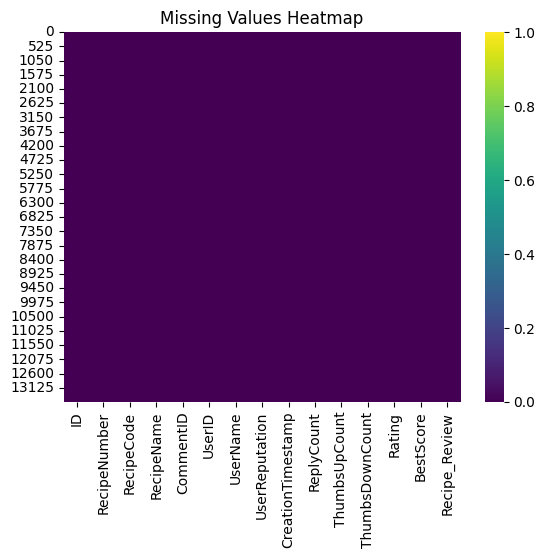

In [4]:
missing_values = data.isnull().sum()
print(missing_values)

sns.heatmap(data.isnull(), cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# 1. Univariate Analysis

# - Target Frequency and distribution

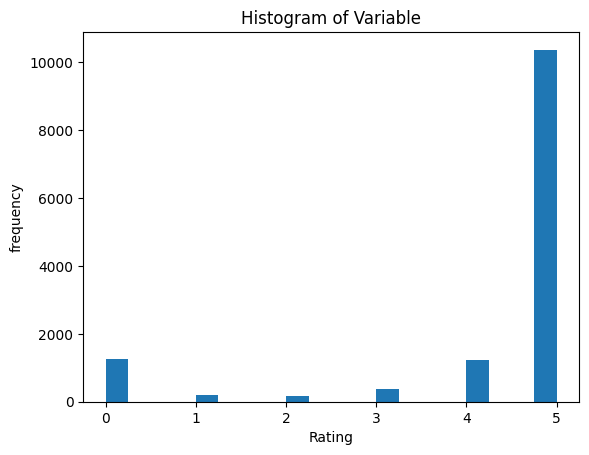

In [5]:
plt.hist(data[['Rating']], bins=20)
plt.xlabel('Rating')
plt.ylabel('frequency')
plt.title('Histogram of Variable')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


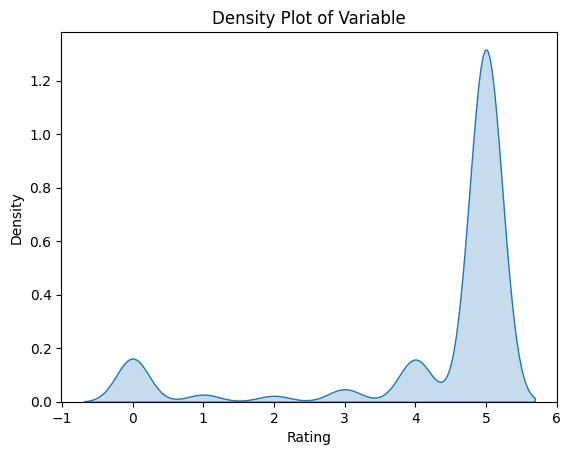

In [6]:
sns.kdeplot(data['Rating'], fill=True)
plt.title('Density Plot of Variable')
plt.show()

# 2. Multivariate Analysis

# - Correlation Analysis

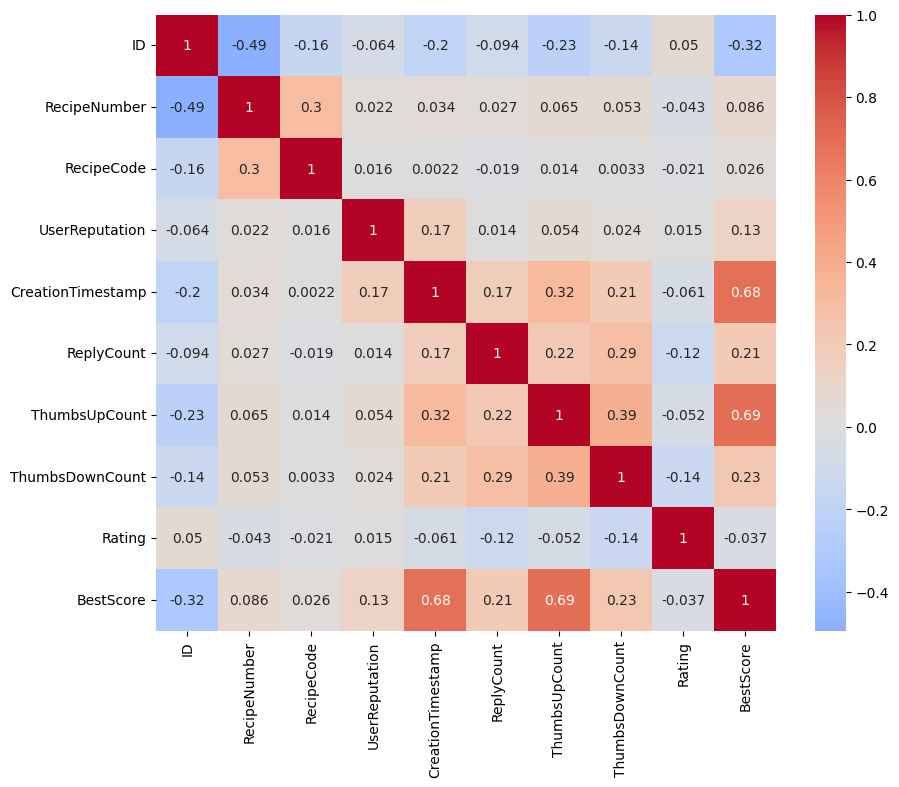

In [7]:
matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', center=0)
plt.show()


# EDA Summary

**1. Basic Stats Description Analysis** 

    1. There are no outlier in the data set
    2. There missing values only in recipe_review column 

**2. Univariate Analysis** 

    1. we found that rating 5 is highly distributed across the train data 
    
**3. Multivariate Analysis** 

    1. Pairplot & corrleation analysis 
    
        1. From PairPlot and correction analysis we have found following pairs are Resonably correlated 
            - (BestScore,ThumbsUpCount)
            - (BestScore, CreationTimeStamp)
            
    2. None of the Numerical Variables are correlated with target variable Rating
     

---------------------------------------------------------------------------------------------

 # DATA PREPROCESSING
 
**Catgorical variables preprocessing**

  1. recipe_review tokenization (count vectorization) (imputation 'unknown')
  2. Recipie code (ordinal encoding)

**Numerical variables preprocessing (scaling to avoing convergence issues)**

 1. user reputation 
 2. timestamps 
 3. best score
 
**unprocesed numerical variables**
 
 1. reply count 
 2. thumbsup count 
 3. thumbsdown count 
 
**Columns to Drop**

 1. Dropping comment id, user_id since its unique 
 2. Dropping RecipeName since it can be identified by recipie code 
 3. Dropping UserName since we can encode userid with ordinal encoding
 4. Dropping ID since it has no contribution towards target 

In [8]:
data['Recipe_Review'] =  data['Recipe_Review'].fillna('Unknown').copy(deep=True)
data_test['Recipe_Review'] = data_test['Recipe_Review'].fillna('Unknown').copy(deep=True)

data['Recipe_Review'] = data['Recipe_Review'].str.lower().str.replace('[^\w\s]', '', regex=True).copy(deep=True)
data_test['Recipe_Review'] = data_test['Recipe_Review'].str.lower().str.replace('[^\w\s]', '', regex=True).copy(deep=True)

columns_to_drop = ["CommentID","RecipeName", "UserName", "ID","UserID"]

data = data.drop(columns_to_drop,axis = 1).copy(deep=True)
data_test = data_test.drop(columns_to_drop,axis = 1).copy(deep=True)


Y = data["Rating"].copy(deep=True)
X = data.drop("Rating",axis = 1).copy(deep=True)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Vectorization (vectorizing the recipie review) 

In [9]:

text_vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,1))


X_review_vectorized = text_vectorizer.fit_transform(X["Recipe_Review"]).toarray()
data_test_review_vectorized = text_vectorizer.transform(data_test["Recipe_Review"]).toarray()
X_train_review_vectorized = text_vectorizer.transform(X_train["Recipe_Review"]).toarray()
X_test_review_vectorized = text_vectorizer.transform(X_test["Recipe_Review"]).toarray()


X = X.drop("Recipe_Review",axis = 1).copy(deep=True)
data_test = data_test.drop("Recipe_Review",axis = 1).copy(deep=True)
X_train = X_train.drop("Recipe_Review",axis = 1).copy(deep=True)
X_test = X_test.drop("Recipe_Review",axis = 1).copy(deep=True)

# Pipeline Transformation and Data Merge

In [10]:

ct = ColumnTransformer(transformers=[("ordinal_encoding", OrdinalEncoder(),["RecipeCode"]),
                                     ("standardization", MinMaxScaler(),["BestScore","UserReputation","CreationTimestamp"])
                                    ], remainder="passthrough")

preprocessing_pipline = Pipeline(steps=[
                                            ("col_tran", ct),
                                    #        ("pca",PCA(n_components=0.95))
                                    ]) # get pca that explains 95% variance




transformed_X = preprocessing_pipline.fit_transform(X)

transformed_train = preprocessing_pipline.transform(X_train)

transformed_test = preprocessing_pipline.transform(X_test)

transformed_X_test = preprocessing_pipline.transform(data_test)

transformed_X = np.hstack((X_review_vectorized, transformed_X))
transformed_train = np.hstack((X_train_review_vectorized, transformed_train))
transformed_test = np.hstack((X_test_review_vectorized, transformed_test))
transformed_X_test = np.hstack((data_test_review_vectorized, transformed_X_test))

-----------------------------------------------------------------------------------------------

# MODELS ANALYSIS

---------------------

# Hyper Parameter Tuning using Grid CV

# 1. Logistics Regression (Grid CV)

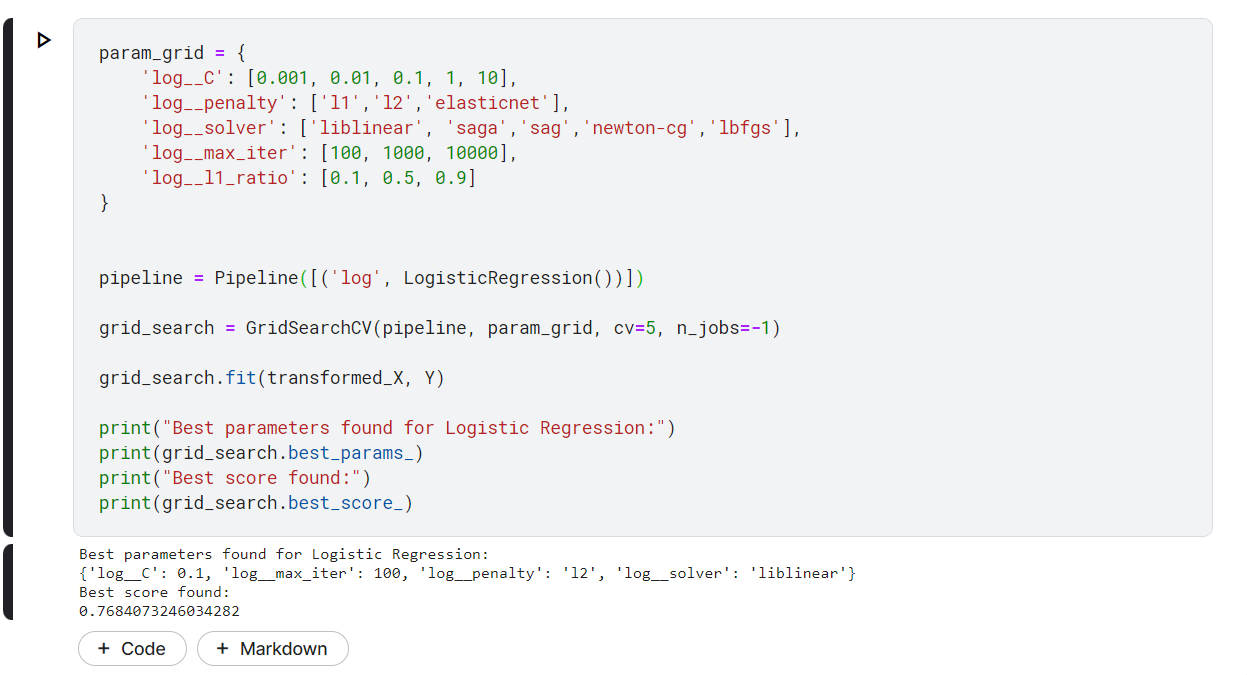


# 2. Support Vector Machine (Grid CV) 

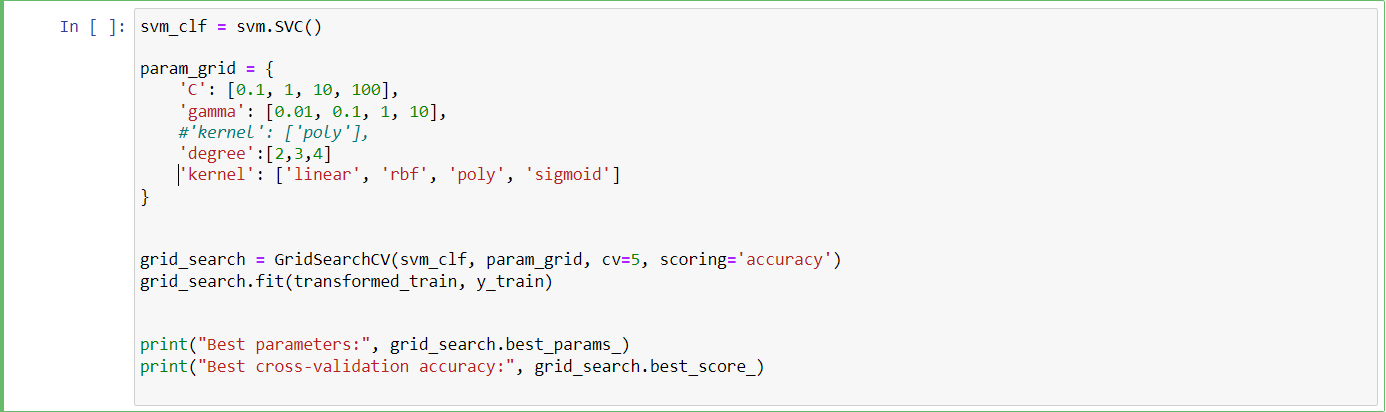

 **SVM with polynomial and Radial Basis Kernel**
 
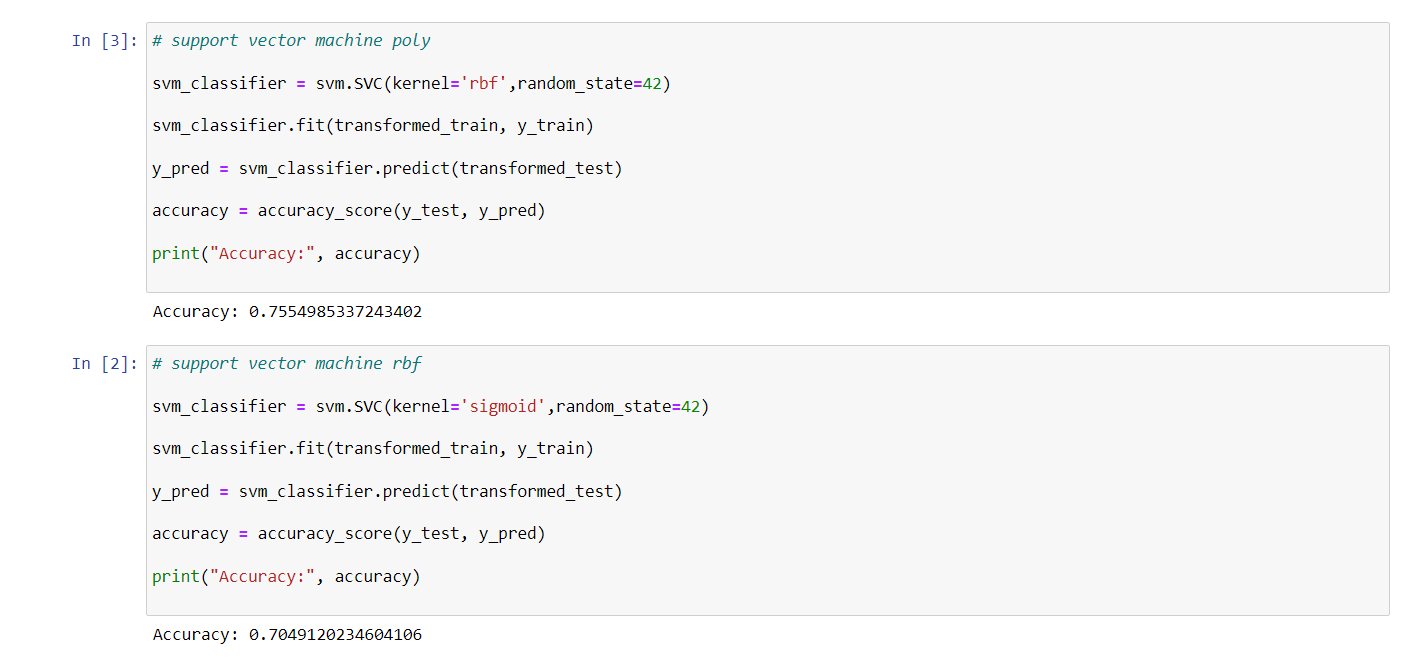


# 3. KNN (GRID CV)

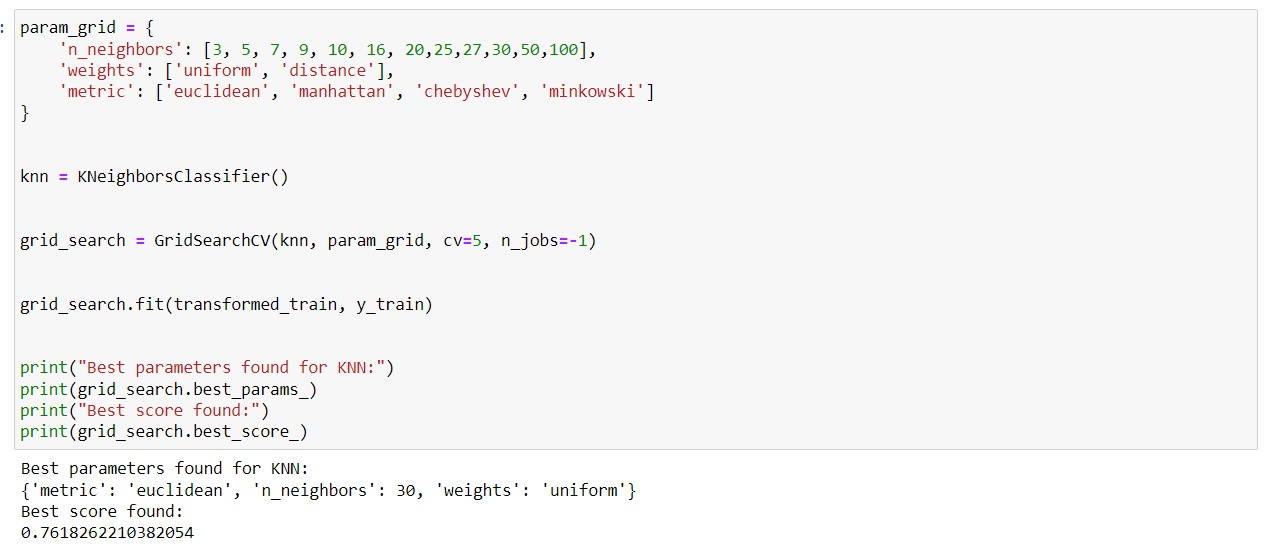


# 4. Descision Tree (GRID CV)

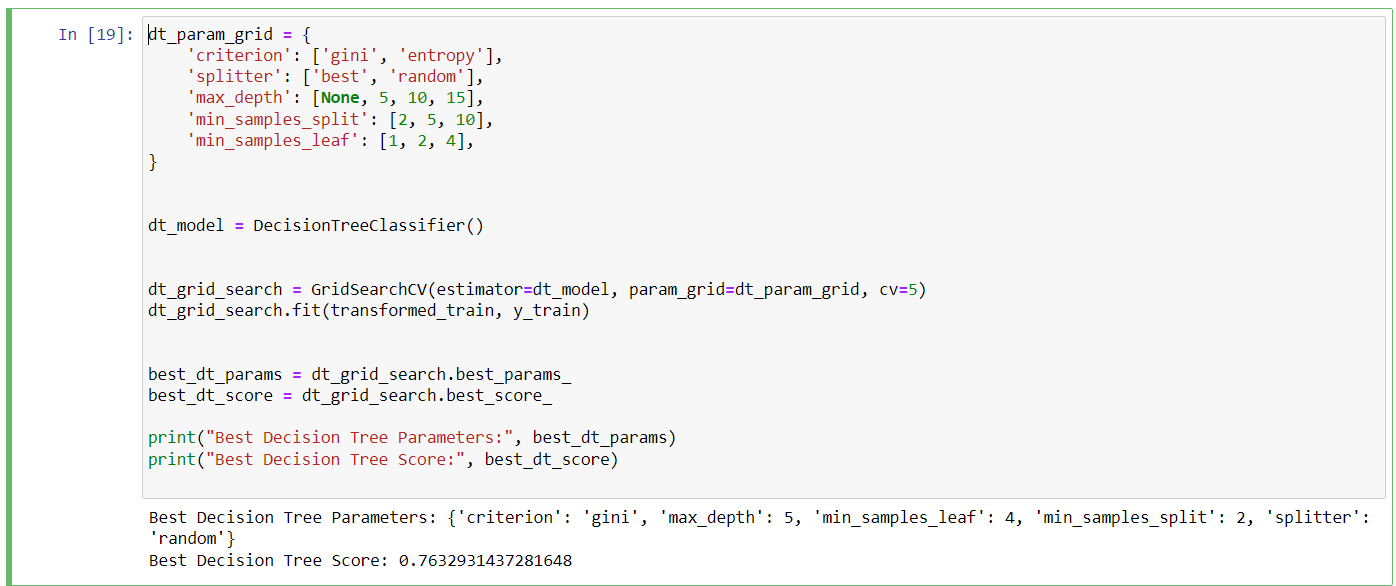


# 5. BAGGING Random Forest (Grid CV) 

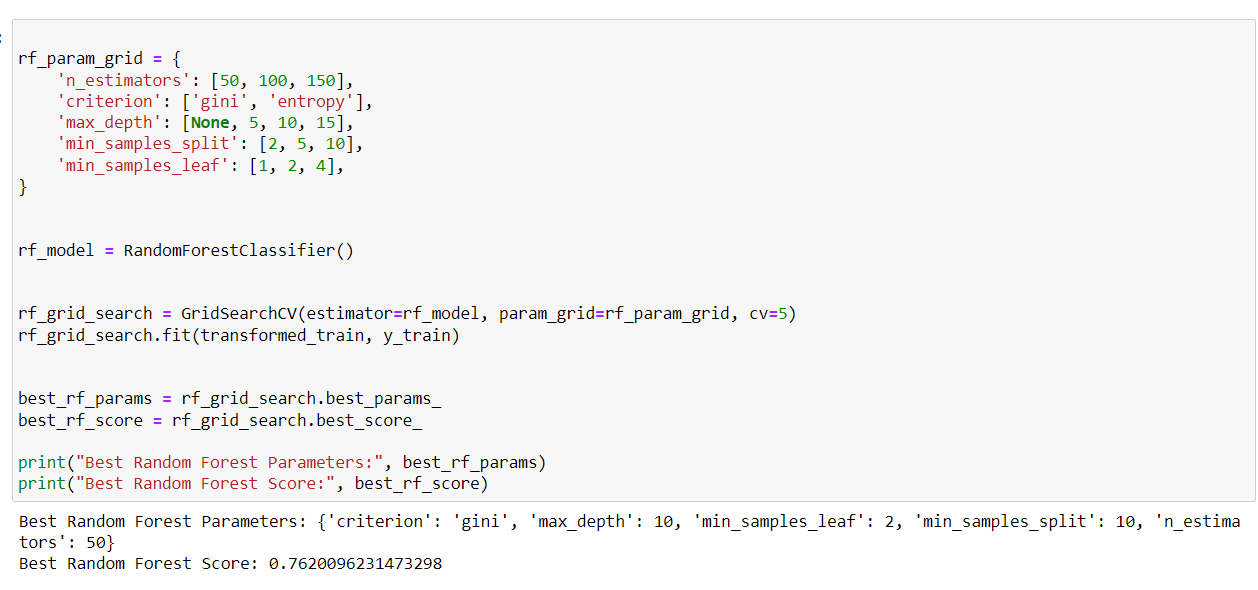


# 6. Boosting: ADA Boosting (Grid CV)

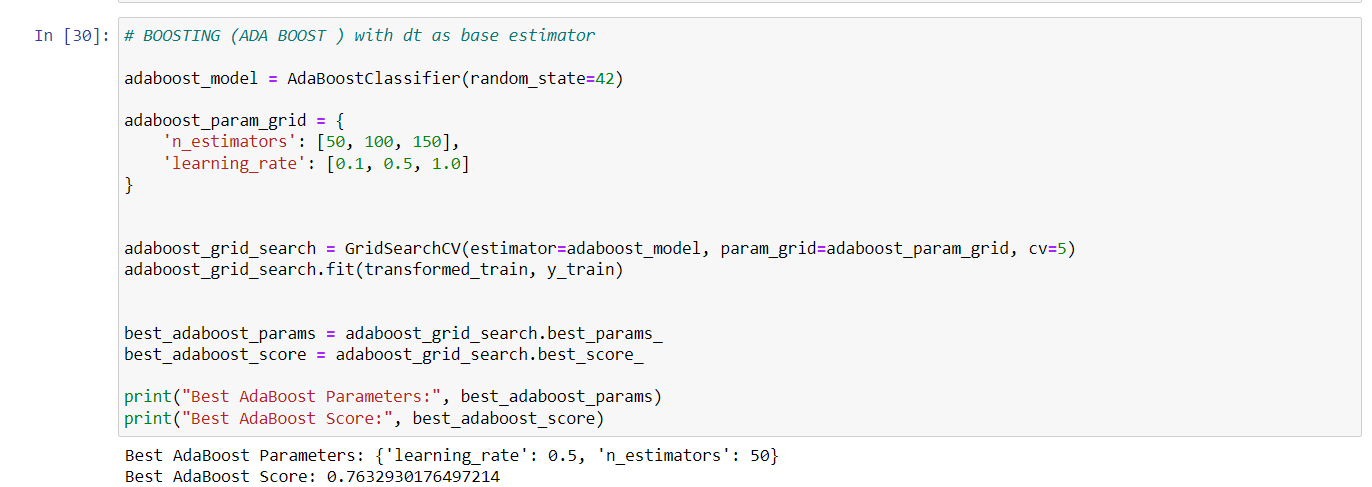


# 7. Boosting: Gradient Boosting (Grid CV)

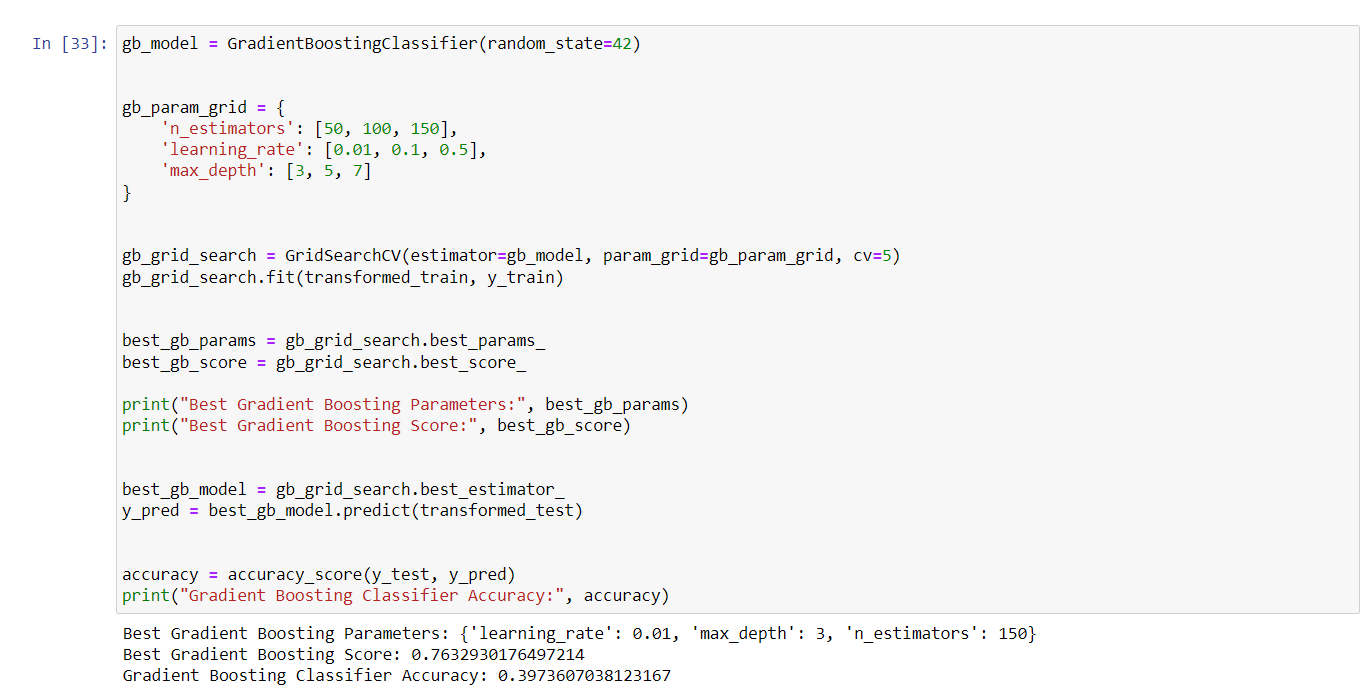

# 8. MLP (MultiLayer Preceptron)

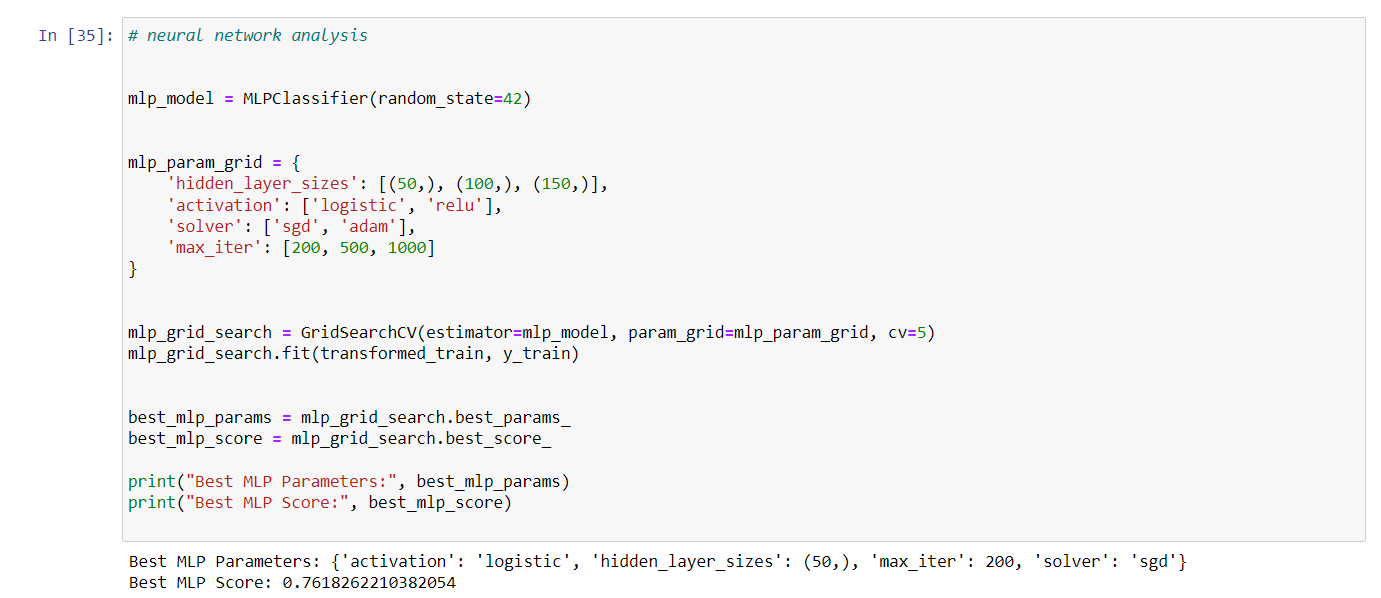

--------------------

# Model Selection

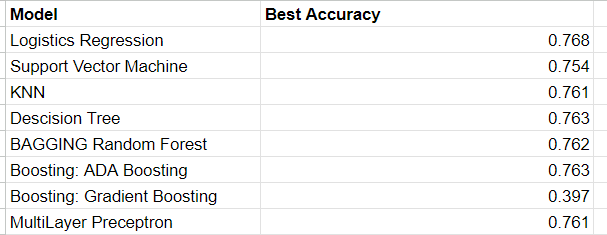



# Top 3 Models (Based on best score and training time)

1. Logistics Regression 
2. KNN
3. BAGGING (Random forest)

------------------------------------------------------------------------------

# 1. Logistics Regression 

**D2 Train Data (Only Tokenized Recipie Review Column)** 

In [11]:
log_model_liblinear = LogisticRegression(max_iter=100,solver="liblinear",C=0.1, penalty='l2')  

log_model_liblinear.fit(transformed_X,Y)

log_model_liblinear_y_pred_combined = log_model_liblinear.predict(transformed_X_test)

**D1 Train Data (All Columns except dropped ones)** 

In [12]:
log_model_liblinear = LogisticRegression(max_iter=100,solver="liblinear",C=0.1, penalty='l2')  

log_model_liblinear.fit(X_review_vectorized,Y)

log_model_liblinear_y_pred_review = log_model_liblinear.predict(data_test_review_vectorized)


In [13]:
accuracy_score(log_model_liblinear_y_pred_combined, log_model_liblinear_y_pred_review)

0.9828420589529256

# D1 and D2 data analysis

**1. As we can see D1 and D2 Data almost preforms similar to predict Target Variable**

-----------------------------------------------------------------------------------------------

# KNN (K nearest Neighbour)

**D2 Train Data (Only Tokenized Recipie Review Column)** 

In [14]:
knn = KNeighborsClassifier(n_neighbors=30,weights='uniform',metric='euclidean')
knn.fit(X_review_vectorized,Y)
knn_vectorized_ypred =  knn.predict(data_test_review_vectorized)

**D1 Train Data (All Columns except dropped ones)** 

In [15]:
knn_combined = KNeighborsClassifier(n_neighbors=30,weights='uniform',metric='euclidean')
knn_combined.fit(transformed_X,Y)
knn_ypred =  knn_combined.predict(transformed_X_test)

In [16]:
accuracy_score(knn_ypred,knn_vectorized_ypred)

0.9848218213814343

# KNN Analysis 

1. KNN both perfroms almost same in D1 and D2 input data

2. KNN accuracy is lesser when compared to logistics regression in submission test data

---------------------------------------------------------------------------------------------------

# Bagging Random Forest

**D2 Train Data (Only Tokenized Recipie Review Column)** 

In [17]:
rclf = RandomForestClassifier(criterion= 'gini', max_depth= 10, min_samples_leaf= 2, min_samples_split= 10, n_estimators=50)
rclf.fit(X_review_vectorized,Y)
rclf_y_pred =  rclf.predict(data_test_review_vectorized)

**D1 Train Data (All Columns except dropped ones)** 

In [18]:
rclf_combined = RandomForestClassifier(criterion= 'gini', max_depth= 10, min_samples_leaf= 2, min_samples_split= 10, n_estimators=50)

rclf_combined.fit(transformed_X,Y)
rclf_combined_y_pred =  rclf_combined.predict(transformed_X_test)

In [19]:
accuracy_score(rclf_combined_y_pred, rclf_y_pred)

1.0

# Random Forest Analysis 

1. Random forest performs exactly same with D2 and D1 input vector
2. logistics regression has better accuracy than random forest 


-------------------------------------------------------------------------------------------------

# Final Submission

**From analysis we have found logistis regression performs better in given dataset interms of accuracy**

In [20]:
id = [i for i in range(1,4547)]
sub = pd.DataFrame(id, columns=['ID'])
sub['Rating'] = log_model_liblinear_y_pred_review
sub.to_csv("submission.csv", encoding='utf-8',index=False)
output = pd.read_csv("submission.csv")

-------------------------------------------------------------------------------------------------